## Load Libraries and import modules 

In [55]:
# Load all the vanila libraries 
import numpy as np
import pandas as pd
import numpy.random as nrd
import os
import re
import pathlib 
import sys
from typing import Callable


# ml packages
import umap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Pytorch modules 
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.distributions.continuous_bernoulli import ContinuousBernoulli 

# this for the custom Dataset 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import plotly.graph_objects as go



# Import tqdm for progress bar
from tqdm.auto import tqdm

# for timing functions
from timeit import default_timer as timer 

### Configure Project Parameters

In [56]:
# check your current directory
os.getcwd()

'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space'

**Important:** Run the configuration file first `configs.py`. Importing this script and setting the seed and device parameters before importing any of the other modules ensures that evereything is sync.

**Important** If you want *change the configuration parameters*, change them before importing and running the pipeline. 

In [57]:
from models_util import configs

In [58]:
configs.get_configs()

'Seed: 156, Device: cpu'

In [59]:
# print the global variables
print(configs.project_seed, configs.project_device)

156 cpu


In [60]:
configs.set_seed(156)
device = configs.set_device(force_cpu=True)

# global variables have changed too
print(configs.project_seed, configs.project_device)

During configuration random seed 156 has been set.
156 cpu


In [61]:
# lets see if the get function also agrees:
configs.get_configs()

'Seed: 156, Device: cpu'

Now that all the configurations values are assigned globally, we can import the modules. If this is working, we expect each module to access the **same** **seed** and **device** we set. We are also expecting generated numbers **inside the modules** to be reproducible.

In [62]:
# Load home modules and check the device where they are running 
from models_util import utility_functions as uf

In [63]:
from models_util import custom_dataset as cd

In [64]:
from models_util import cost_functions as cf

In [65]:
from models_util import VAE1 as v1 


In [66]:
from models_util import VAE2 as v2 


## SCBC Data scale and split for VAE
- We will perform min-max scaling to the TMT-Ratios of the proteomic SCBC data. <br>
- We will scale the array version of our scbc data, the `npscbc` matrix.
- Then we will copy this scaled matrix and reshuffle the copy. The `npscbc_scaled_shuffled` will be used for the model training and performance evaluattion. <br>
- The `npscbc_scaled` matrix with the original order of rows will be used later for the validation of the latent variables. <br> 
- It is important to use the non-missing min and max values of dataset row-by-row <br>

In [120]:
# create path and read the scbc data
data_path = os.getcwd() + "\\data\\processed\\" 

# scbc protein (gene centric) table
scbc = pd.read_csv(data_path+"protein_quant_merged.txt",delimiter="\t")

# scbc proteoform (dominants - sims) table
# scbc = pd.read_csv(os.getcwd() + "\\data\\features\\scbc_quant_sims.csv", index_col=0)



        #########  IMPORTANT GLOBAL VARIABLES FOR NAMING DIRECTORIES AND FILES   ##########



n="g2simSCBC_noscale_" # initials of the model - CHANGE IT AS YOU SEE FIT - will be used for model directory folder and saving results in
data_type = "sim" # switch to protein if its protein tables, will be used for saving files 

#### Put initials that are usefull for model and data usage #####

# gpep -> proteoform peptides in gaussian model 
# gprot -> proteins in gaussian model 
# gsim -> proteoform dominants in gaussian model
# SCBC -> subcellular MS proteomics data
# noscale -> data was not scaled before training the model 

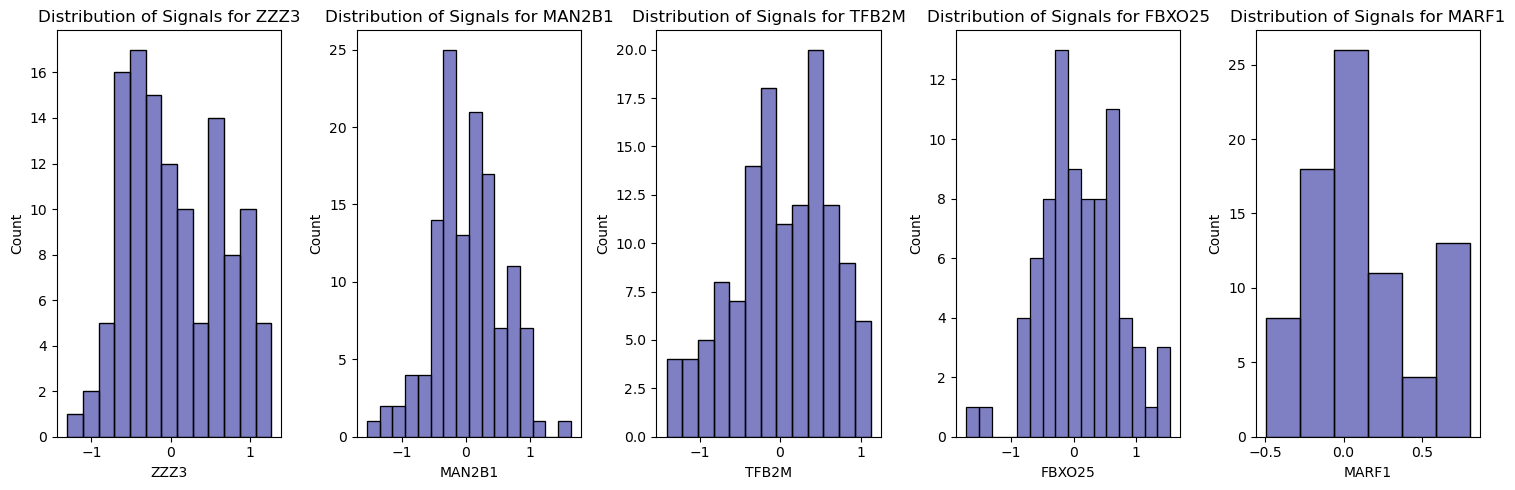

In [121]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
rand_idx = nrd.randint(0,scbc.shape[0],5)

for i,idx in enumerate(rand_idx):
    sns.histplot(scbc.iloc[idx,:], binwidth=.2,ax=ax[i], color="darkblue", alpha=.5)
    ax[i].set_title("Distribution of Signals for " + str(scbc.index[idx]))
    plt.tight_layout()
plt.show()

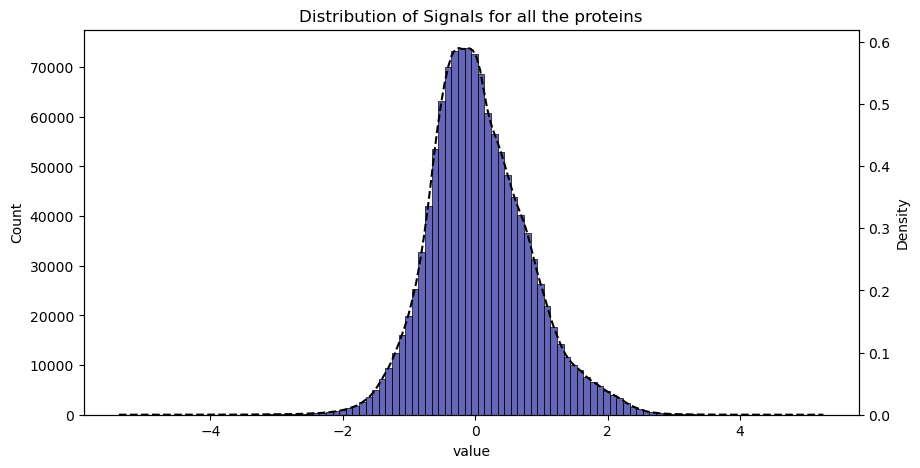

In [122]:
# distribution of all the proteome signals - keep the protein names for outlier analysis 
fig, ax = plt.subplots(1,1,figsize=(10,5))
scbc.melt().pipe((sns.histplot, "data"), x="value", binwidth=.1, ax=ax, color="darkblue", alpha=.6)
ax2 = ax.twinx()
sns.kdeplot(scbc.melt(),x = "value", ax=ax2, color="black", ls = "--")
# ax.set_xlim(-4,5)
ax.set_title("Distribution of Signals for all the proteins")
plt.show()

In [123]:
(scbc.isna().sum(axis=1) > 0.3*scbc.shape[1]).sum()

np.int64(1452)

In [124]:
# convert to numpy 
npscbc = scbc.to_numpy()
np.isnan(npscbc).sum()


np.int64(104200)

In [125]:
# # Get extreme values (non-missing) frome ach row. 
# scbc_min = np.nanmin(npscbc, axis=1, keepdims=True)  # minimum among non-NaN
# scbc_max = np.nanmax(npscbc, axis=1,keepdims=True)  # maximum among non-NaN

# # check that that shapes and values are as expected 
# print(scbc_max.shape,scbc_min.shape,np.isnan(scbc_max).sum(), np.isnan(scbc_min).sum())

# # scake the matrix 
# npscbc_scaled = (npscbc - scbc_min) /(scbc_max - scbc_min + 1e-8)
# npscbc_scaled.shape


In [126]:
# try a z-score normalization
# npscbc_scaled = StandardScaler().fit_transform(npscbc.T).T

# try no normalization 
npscbc_scaled = npscbc.copy()

In [127]:
# shuffle the rows but keep scaled original
npscbc_scaled_shuffled = npscbc_scaled.copy()
np.random.shuffle(npscbc_scaled_shuffled)
# npscbc_scaled[1,],scbc.iloc[1,:12]

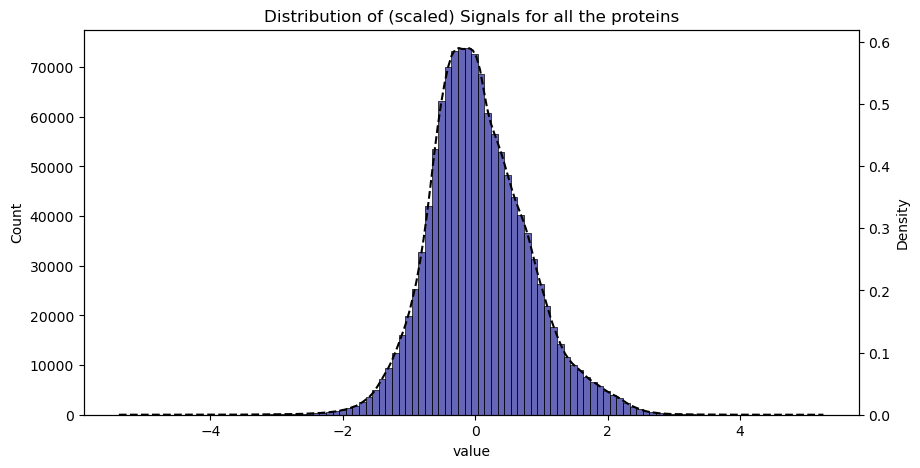

In [128]:
# distribution of all the proteome signals - keep the protein names for outlier analysis 
fig, ax = plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(npscbc_scaled, columns=scbc.columns).melt().pipe((sns.histplot, "data"), x="value", binwidth=.1, ax=ax, color="darkblue", alpha=.6)
ax2 = ax.twinx()
sns.kdeplot(pd.DataFrame(npscbc_scaled, columns=scbc.columns).melt(),x = "value", ax=ax2, color="black", ls = "--")
# ax.set_xlim(-4,5)
ax.set_title("Distribution of (scaled) Signals for all the proteins")
plt.show()


### Split Data 

In [129]:
train_data, val_data, test_data = uf.create_data_partition(
    npscbc_scaled_shuffled, test_perc=0.15, val=True, val_perc=0.1
)
train_data.shape, val_data.shape, test_data.shape

((7829, 130), (1044, 130), (1566, 130))

You can test reproducibility by re-runing the function and checking the data in the first index of the matrix. We expect it to be the same. 

In [130]:
# train_data[1,]

### Pass data to Custom Dataset and DataLoaders 
- check that your data is numpy matrix.
- check if data is scaled to (0,1).
- create three custom dataset instances.
- the custom dataset will save all the data to memory and create a mask where NaNs are located.
- the numpy arrays will be converted to tensors of appropriate dimensions and NaNs to zeroes.
- then we pass the custom dataset to the dataloader object.
- The DataLoader object contains for each row (training example) i) a tensor of 1 x 130 columns with 0-1 scaled values, ii) a 1x130 mask indicating NA positions and iii) index of the examples per batch (could be 64, 128,..., batch_size). 

In [131]:
train_dataset = cd.ProteinDataset(train_data)
val_dataset = cd.ProteinDataset(val_data)
test_dataset = cd.ProteinDataset(test_data)

Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified
Protein Dataset is passed to memory
No Protein Symbols were identified


In [132]:
# pass data to the dataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,drop_last=True)

In [133]:
# the train loader is not reproducible bcs it shuffles but it is not seeded yet. 
# here is one batch of training examples 
# torch.manual_seed(888)


# next(iter(train_loader))

## Training-Validation Loop 
It comprises the run of the training and validation set. VAE inherently have a tendency to overfit, so it is important to keep the test set after training loop. In this tutorial we run one model. The name is based on a simple numbering system and its layers to track it down. Furthermore the train_val_loop creates a hyperparameter string to track other parameters. The whole loop is parametrized in a function: <br>
- The function starts with a pre-training evaluation to initialize metrics at epoch = 0 <br>
- Then training of the model begins and after each epoch, the validation set is passed through the model to get the validation - epoch metrics.<br>


During training, these are computed:
- KL, Gaussian Logliklihood error, and Total Error are monitored per training batch, and also averaged every n batches.
- KL, Gaussian Logliklihood error, and Total Error are monitored per validation round (per epoch).

In [134]:
hidden_dim = 90
latent_dim = 45
  

# Instantiate the model, v1 shallow VAE with no activation function to the output 
model1 = v1.VAE(
    n_features=130,
    latent_dim=latent_dim,
    hidden_layer=True,
    hidden_dim=hidden_dim,
    output_activ = None
).to(device)

# model2 = v2.VAE(n_features=130,
#               latent_dim=45,
#               hidden_layer= True,
#               hidden_dim_1=100,
#               hidden_dim_2=75,
#               sigmoid=True).to(device)


# need to set the model name with the layers - usefull for creating its unique folder 
model_name = f"model_{n}_{hidden_dim}_{latent_dim}"
 

# Create a "models" folder and the specifics model's directory to save figures  
# create the models directory path 
path_dir = os.getcwd() + "\\models"

# Check if the models directory exists, if not, create it
if not os.path.exists(path_dir):
    os.makedirs(path_dir)
    print(f"Created directory: {path_dir}")
else:
    print(f"Directory already exists: {path_dir}")

# create a subdirectory for each model based on #number and name (the dims of layers)
model_path = os.path.join(path_dir,model_name)
if not os.path.exists(model_path):
    os.makedirs(model_path)
model_path


## Final Important part

# set all the parameters to variables because all functions of this pipeline depend on them
model = model1
loss_fun = cf.loss_fun_gauss
model_name=model_name
path=model_path
epoch = 200
learn_r = 0.0025
freebits = 2.0
patience = 7
batch_size = 128
norm = 0

# the path where this model is going to be saved 
model_path

Directory already exists: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models


'c:\\Users\\gpano\\Desktop\\github_py\\proteomics_latent_space\\models\\model_g2simSCBC_noscale__90_45'

In [135]:
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=130, out_features=90, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=90, out_features=90, bias=True)
  )
  (decoder_common): Sequential(
    (0): Linear(in_features=45, out_features=90, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.1)
  )
  (head_mu): Sequential(
    (0): Linear(in_features=90, out_features=130, bias=True)
  )
  (head_logvar): Linear(in_features=90, out_features=130, bias=True)
)

In [136]:
# He initialization - i found no difference 
# model.init_weights()

In [137]:
# x = next(iter(model1.modules()))
# x.encoder[0].weight

In [138]:
# Run the loop - see the parameters 
# extract the batch, epoch data and the parameters string

# set global seed 
torch.manual_seed(configs.get_seed())

batch_dict, epoch_dict,hyperparam_str = uf.train_val_loop(
model = model,
train_loader=train_loader,
val_loader=val_loader, 
loss_fun = loss_fun,
model_name=model_name,
model_path=path,
epoch = epoch,
patience=patience,
learn_r = learn_r,
freebits = freebits,
batch_size = batch_size,
norm = norm,
information=True
)

  0%|          | 0/201 [00:00<?, ?it/s]

Performing pre-training evaluation on the model in epoch 0

Val loss: 63.623| Val KL: 62.38324737548828 | Val Rec: 1.240

Epoch 1
--------------------
Train loss: 63.150|Train Rec: 0.744 | Val loss: 62.790, Val Rec: 0.402

Epoch 2
--------------------
Train loss: 62.793|Train Rec: 0.387 | Val loss: 62.734, Val Rec: 0.350

Epoch 3
--------------------
Train loss: 62.727|Train Rec: 0.327 | Val loss: 62.617, Val Rec: 0.233

Epoch 4
--------------------
Train loss: 62.668|Train Rec: 0.268 | Val loss: 62.597, Val Rec: 0.212

Epoch 5
--------------------
Train loss: 62.651|Train Rec: 0.251 | Val loss: 62.565, Val Rec: 0.179

Epoch 6
--------------------
Train loss: 62.616|Train Rec: 0.220 | Val loss: 62.554, Val Rec: 0.168

Epoch 7
--------------------
Train loss: 62.606|Train Rec: 0.208 | Val loss: 62.555, Val Rec: 0.166

Epoch 8
--------------------
Train loss: 62.602|Train Rec: 0.204 | Val loss: 62.520, Val Rec: 0.134

Epoch 9
--------------------
Train loss: 62.586|Train Rec: 0.190 | Val

In [139]:
# Finally create a model id which is comprised by the model_name and training hyperparameters
model_id = model_name + "_" + hyperparam_str
model_id

'model_g2simSCBC_noscale__90_45_ep95_norm0_bits2.0_bs128_lr0.001'

## Train-Val Diagnostics 

In [140]:
#The path for all the figures related to the models performance 
path = model_path
path

# extract the total epochs run for this model based on its hyperparam_string that was generated by the train-val loop 
m = re.search("ep(\d+)",hyperparam_str, re.IGNORECASE)
epoch_run = int(m.group(1)) + 10
epoch_run

<>:6: SyntaxWarning:

invalid escape sequence '\d'

<>:6: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\gpano\AppData\Local\Temp\ipykernel_3368\1267810632.py:6: SyntaxWarning:

invalid escape sequence '\d'



105

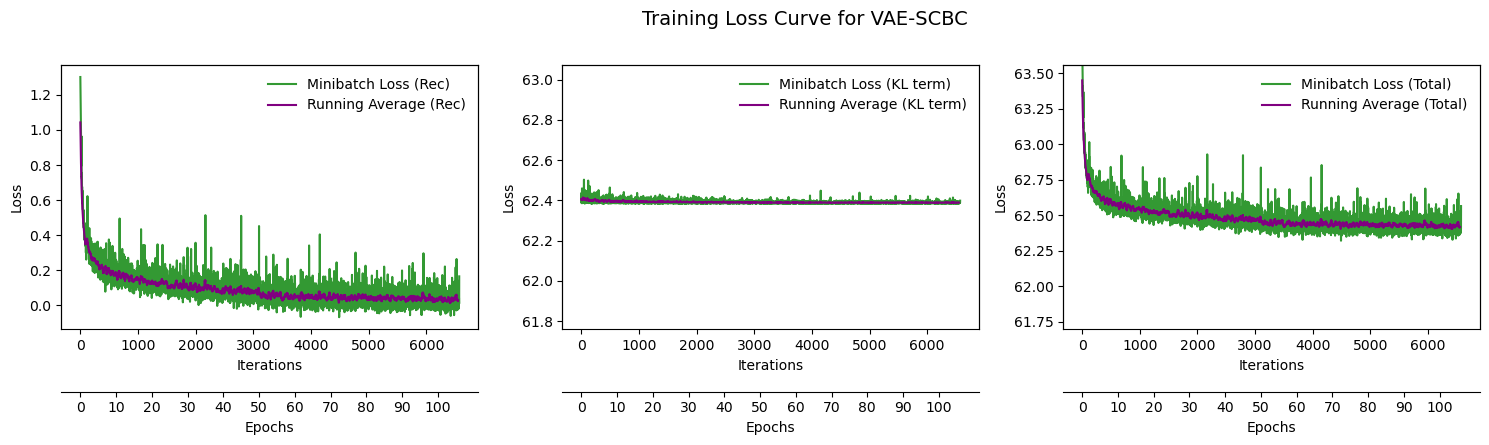

In [141]:
fig, axes = plt.subplots(1,3,figsize=(15,4))

# use the plot trainining_loss_sp function for all the error in the iteration dictionary 
uf.plot_training_loss_sp(axes[0], batch_dict["Train Rec Loss"], epoch_run, averaging_iterations=20, custom_label=" (Rec)")
uf.plot_training_loss_sp(axes[1], batch_dict["Train KL Loss"], epoch_run, averaging_iterations=20, custom_label=" (KL term)")
uf.plot_training_loss_sp(axes[2], batch_dict["Train total Loss"], epoch_run, averaging_iterations=20, custom_label=" (Total)")

fig.suptitle(f"Training Loss Curve for VAE-SCBC",
             y=1.1,x=.54,
             fontsize=14)
axes[0].legend(frameon=False)
axes[1].legend(frameon=False)
axes[2].legend(frameon=False)
plt.subplots_adjust(hspace=0.35)  # Adjust the value as needed

plt.savefig(path + "\\trainloss_curve.png", dpi=600, bbox_inches="tight")
plt.show()

In [142]:
epoch_df = uf.convert_epoch_df(epoch_dict)

   epoch  Train total Loss  Train KL Loss  Train Rec Loss  Val total Loss  \
0      0         63.622827      62.383247        1.239580       63.622827   
1      1         63.150380      62.405925        0.744455       62.789983   

   Val KL Loss  Val Rec Loss  rec_dif    kl_dif  total_dif  
0    62.383247      1.239580  0.00000  0.000000   0.000000  
1    62.387567      0.402415  0.34204  0.018357   0.360396  


df inserted


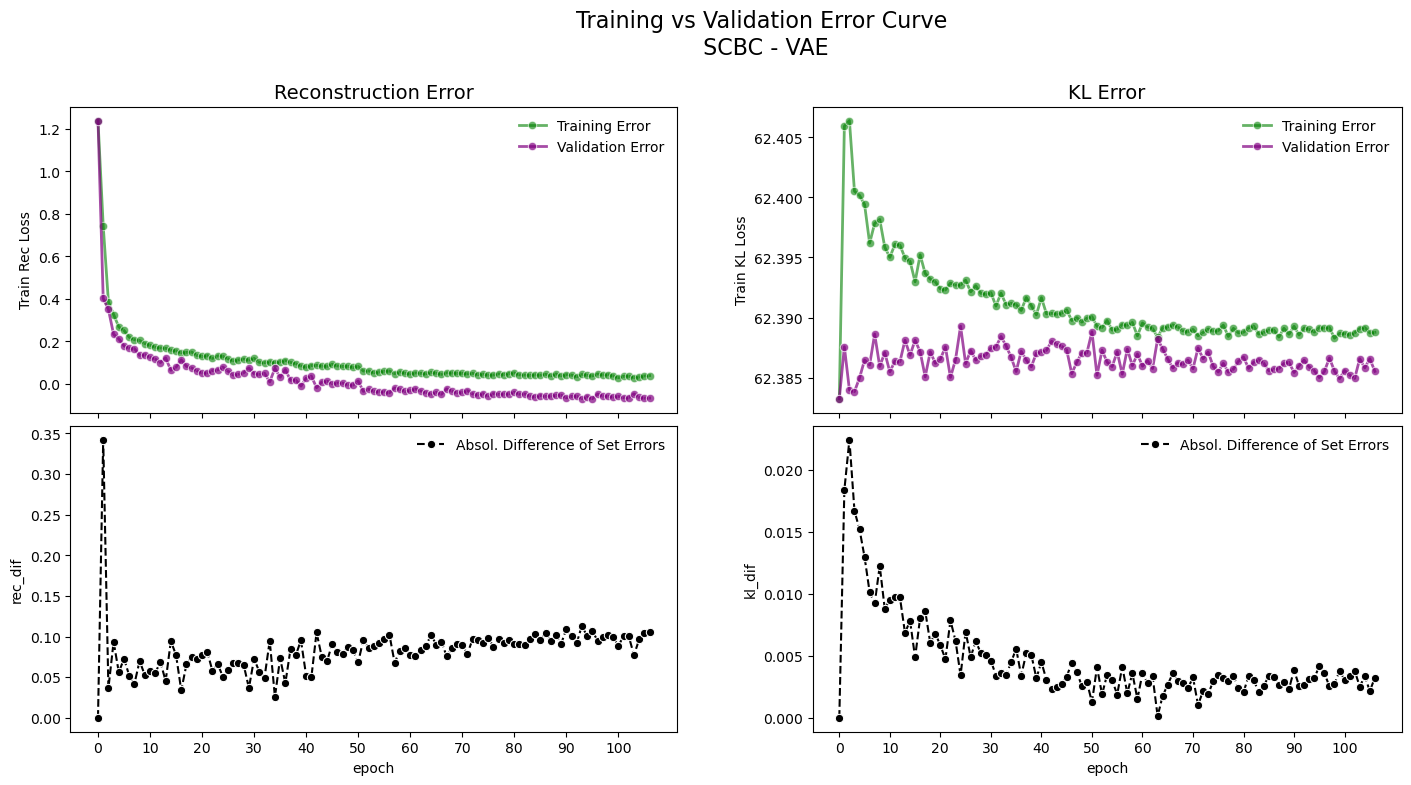

In [143]:
# run this function 
uf.get_train_vs_val_metrics(
    epoch_df=epoch_df,
    epoch=epoch_run,
    plot_title = "SCBC - VAE",
    savepath=model_path
)

## Test Set Analysis 
VAE inherently have a tendency to overfit, even their validation set, so it is important to keep an independent test set after training loop. <br>
During training the model has been evaluated by the val set. However, here we will run the test set to examine **how well it generalizes**.<br> 
Furthermore we will perform **diagnostic tests** for the model's exploratory **latent variables**. <br>


Sometimes the decoder works better than anticipated and it's Reconstruction error is higly **optimistic**. Also, it is quite usual<br>
in the literature that low reconstruction errors might be followed by **distortions in the latent space**. It happens when we try to **over-regularlize** <br>
the KL-error to avoid the **latent collapse** phenomenon. 

Sometimes, there is a **tradeoff** between good reconstructions, and higly informative latent variables.

From the test set I will include **6 criteria**:
- we extract the per batch/losses
- average losses of the whole set 
- kl/dimension from the whole test set. (how information is stored in each dimension?)
- correlation of the different dimensions (are they overlapping in terms of information?)
- investigate actual reconstructions of protein matrices
- perform UMAP and visualize in 3D/2D. We have prior knowledge of this dataset and we expect the formation of clusters. <br>

Furthermore in the optimization script 00b I coupled the latent variables to a logistic regression line to evaluate their predictive value 
of protein-protein interractions. 



In [144]:
test_iter_dict, test_metrics = uf.test_set_analysis(
    model=model,
    test_loader=test_loader,
    loss_fun = loss_fun,
    freebits=freebits,
    model_id=model_id,
    active_func=True
)

Using this model model_g2simSCBC_noscale__90_45_ep95_norm0_bits2.0_bs128_lr0.001
The decoder output is transformed with an activation function, so reoconstructions are scaled.


#### Outputs of Test Set Analysis 
- The putputs of the test set analysis are **two dictionaries**: `test_set_dict` and `test_metrics` 
- The first contains the following keys:
   - `dict_keys(['iteration', 'Test total Loss', 'Test KL Loss', 'Test Rec Loss', 'Test batch index', 'x_orig tensors', 'x_mu tensors', 'masks'])` <br>
   - The first four are floats, the per iteration metrics 
   - The last four are tensors detached from the computation graph
- The `test_metrics` contains the followin keys:
    - `dict_keys(['model_id', 'bits', 'avg_total_loss', 'avg_kl_loss', 'avg_rl_loss'])`
    - vanila python objects 

In [145]:
test_metrics.keys()

dict_keys(['model_id', 'bits', 'avg_total_loss', 'avg_kl_loss', 'avg_rl_loss'])

In [146]:
test_iter_dict.keys()

dict_keys(['iteration', 'Test total Loss', 'Test KL Loss', 'Test Rec Loss', 'Test batch index', 'x_orig tensors', 'x_mu tensors', 'masks'])

In [147]:
pd.DataFrame([test_metrics])
# pd.concat([pd.DataFrame([test_metrics]),pd.DataFrame([test_metrics])],axis=0)

,model_id,bits,avg_total_loss,avg_kl_loss,avg_rl_loss
0,model_g2simSCBC_noscale__90_45_ep95_norm0_bits...,2.0,62.322666,62.38658,-0.063914


### Loss Curves

Using this model model_id


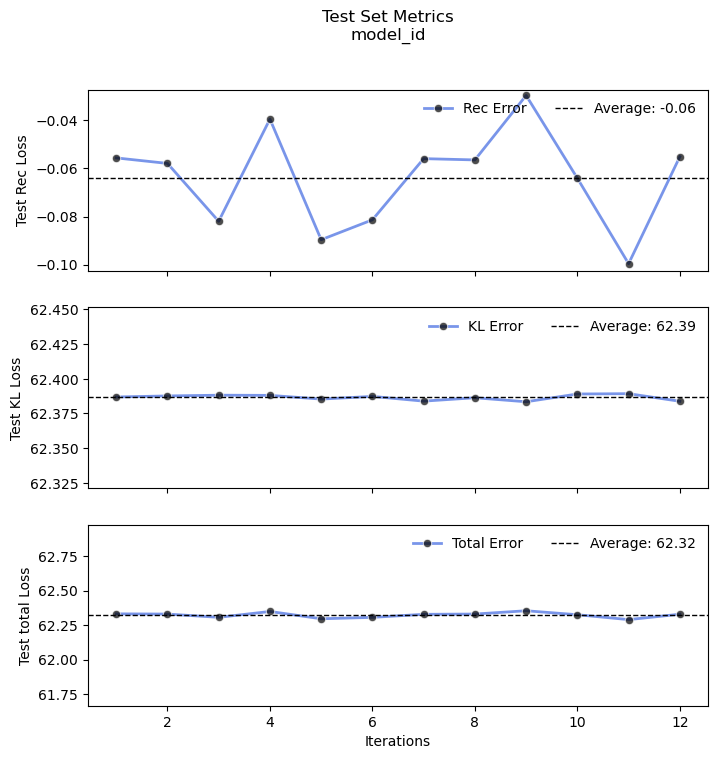

In [148]:
uf.plot_test_losscurves(
    test_iter_dict=test_iter_dict,
    test_metrics=test_metrics,
    model_id="model_id",
    model_path=model_path
)

### Matrix Recosntructions

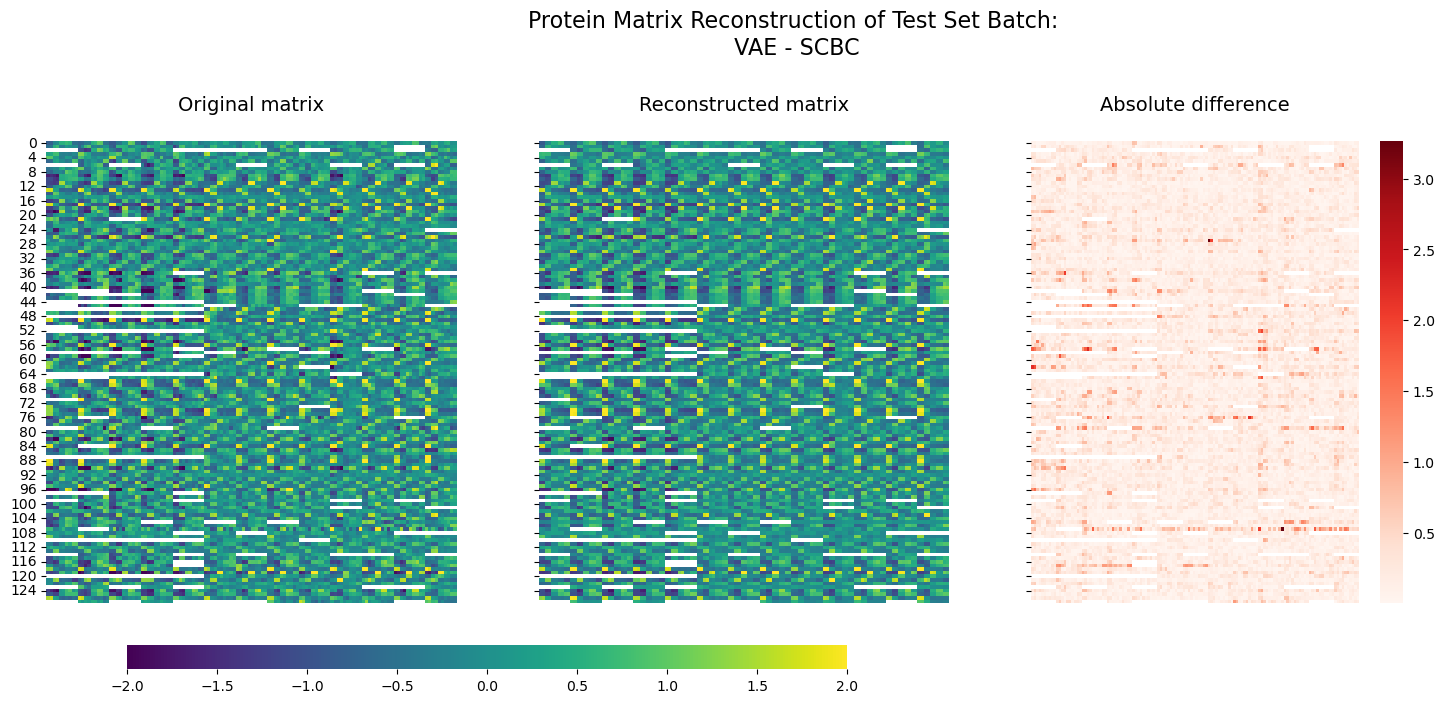

In [149]:
uf.get_matrix_rec(
    test_iter_dict=test_iter_dict,
    model_id="VAE - SCBC",
    model_path=model_path,
    v_min=-2,
    v_max=2
)

### Saturation and Redundanncy Tests


In [150]:
# get latent variables 

model = model
data_loader = test_loader
freebits = freebits

# Nested dictionary
kl_dict = {}
kl_dict['batch_kls'] = {}
kl_dict['batch_stds'] = {}
kl_dict['avg_kl_per_dim'] = None
kl_dict['std_kl_per_dim'] = None
kl_dict["freebits"] = freebits 

# initiate values 
kl_sums = 0
kl_sums_sq = 0
count = 0 

model.eval()
with torch.inference_mode():
    for idx,(xb, ms, _) in enumerate(data_loader):
        xb, ms, = xb.to(device), ms.to(device)

        x_mu, x_logvar, z_mu, z_logvar = model(xb)

        # compute KL dimension wise 
        kl_term = 0.5 * (torch.exp(z_logvar) + z_mu**2 - 1.0 - z_logvar)
        
        kl_sum_batch = kl_term.sum(dim=0)
        avg_kl = kl_sum_batch/kl_term.shape[0]
        std_kl = kl_term.std(dim=0)

        # save batch results
        kl_dict["batch_kls"][idx+1] = avg_kl.cpu().numpy()
        kl_dict["batch_stds"][idx+1] = std_kl.cpu().numpy()

        kl_sums += kl_sum_batch
        kl_sums_sq += kl_term.pow(2).sum(dim=0)
        count += kl_term.shape[0]
    
    avg_kl_perdim = kl_sums / float(count) 
    
    # E[KL^2]
    mean_kl_sq = kl_sums_sq / float(count)   
    
    # variance
    var_kl = mean_kl_sq - avg_kl_perdim**2
    var_kl = torch.clamp(var_kl, min=0.0)
    std_kl_per_dim = torch.sqrt(var_kl)
    
    kl_dict['avg_kl_per_dim'] = avg_kl_perdim.cpu().numpy()
    kl_dict['std_kl_per_dim'] = std_kl_per_dim.cpu().numpy()




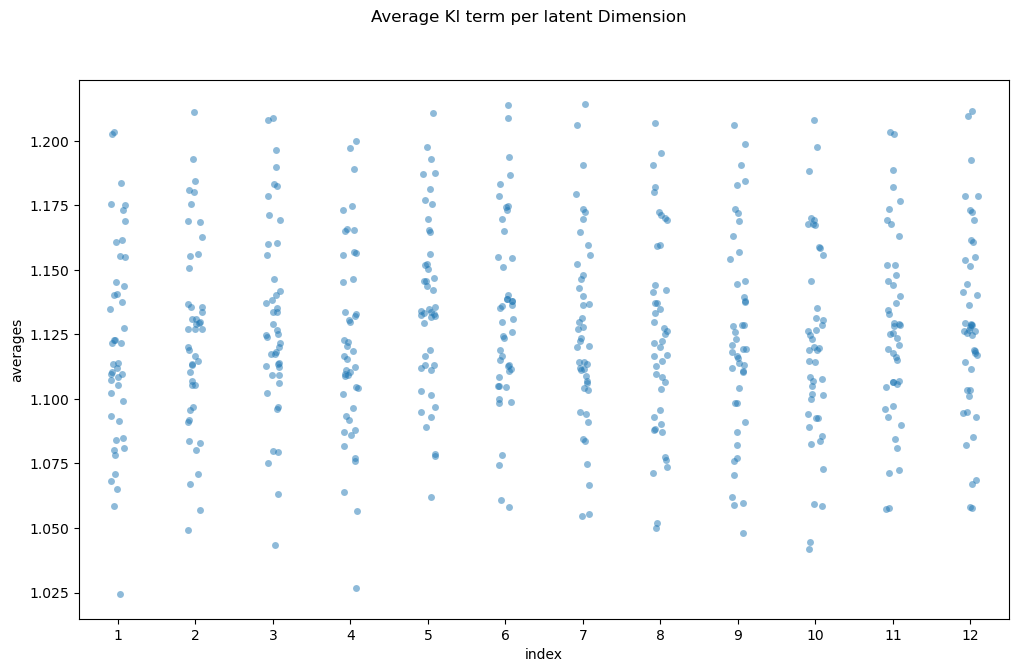

In [151]:
klperdim_df = pd.DataFrame(kl_dict["batch_kls"])
klperdim_df.index = [f"dim{i}" for i in range(1,klperdim_df.shape[0]+1)]
klperdim_df.T
klperdim_df = pd.melt(klperdim_df.T, ignore_index=False,var_name="dimensions",value_name="averages")
klperdim_df.reset_index(inplace=True)

plt.figure(figsize=(12,7))
sns.stripplot(
    data=klperdim_df, x="index", y="averages",
    dodge=True, alpha=.5, legend=False,
)
plt.suptitle("Average Kl term per latent Dimension")
plt.show()

In [152]:
def normalize(x, old_min=-1, old_max=1, new_min=0, new_max=1):
    return (x - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

normalize(0.5)

0.75

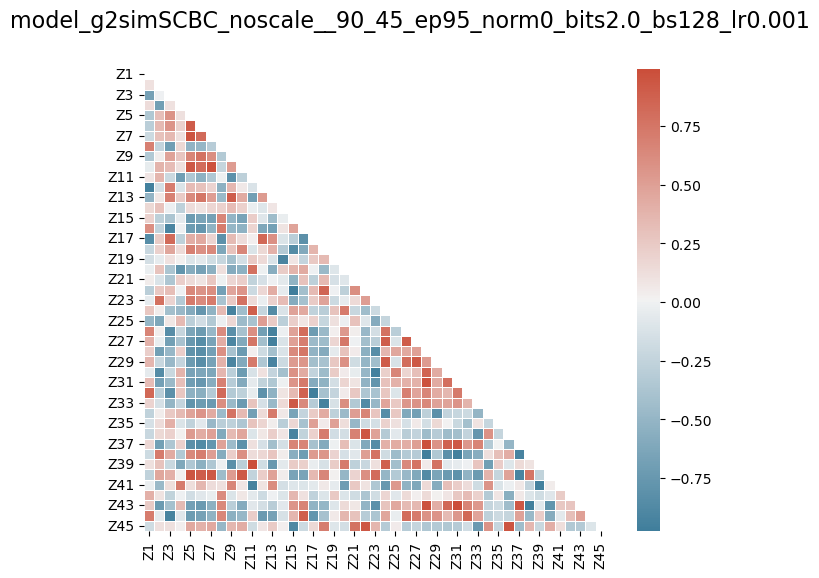

In [153]:

xbatch, tmask, _ =  next(iter(train_loader))
with torch.inference_mode():
    z_mu, z_logvar = model.get_latent_variables(xbatch,detach=True)
# make a dataframe with columns the dmensions of the latent space
dim_cols = [f"Ζ{z}" for z in range(1,z_mu.shape[1]+1)]
dim_df = pd.DataFrame(z_mu.numpy(), columns=dim_cols)
# dim_df

# make a correlation matrix of the latent varables
plt.figure(figsize=(8,6))

# # color codes by matplotlib RGB to decimals
# dark_blue = (39/255, 93/255, 181/255)
# blue = (166/255, 216/255, 235/255) 
# red = (220/255, 39/255, 38/255)  
# gray = (0.85, 0.85, 0.85) 


# # color sections 
# colors = [
#     (0, gray),  
#     (0.325, gray),  # Light Blue
#     (0.325, gray),  # Gray transition
#     (0.75, gray),   # Gray transition
#     (0.75, red),    # Light Red
#     (1.00, (100/255, 39/255, 38/255))  
# ]

cmap = sns.diverging_palette(230, 17, as_cmap=True)
# custom_map = mcolors.LinearSegmentedColormap.from_list('custom_map', colors)

triag_mask = np.triu(np.ones_like(dim_cols,dtype=bool))

sns.heatmap(data=dim_df.corr(), mask=triag_mask, annot=False, cmap = cmap,
            square=True, linewidths=.5)
plt.suptitle(f"{model_id}",fontsize=16)
plt.savefig(path + "\\latent_var_corplot.png", dpi=600, bbox_inches="tight")
plt.show()

In [154]:
print(type(test_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


## Extract and Save the Latent Variables 
- We will used the scaled - non-shuflled matrix because we are interested in retaining the original row order.
- We will perform umap to the latent posterior
- With predefined clusters, we will visualize the effect of the latent variables to their formation.


In [155]:
full_data = DataLoader(cd.ProteinDataset(npscbc_scaled), batch_size=128, shuffle=False)

Protein Dataset is passed to memory
No Protein Symbols were identified


In [156]:
xrec_list = []
latent_list = []
mask_list = []
model.eval()
with torch.inference_mode():
    for batch, mask, idx in full_data:
        batch, mask = batch.to(device), mask.to(device)
        # print(batch.shape, mask.shape)

        # get x_mu
        x_mu, _, _, _ = model(batch) # forward step 
        # print(x_mu.shape)
        xrec_list.append(x_mu.detach().cpu())

        # get z_mu
        z_mu, _ = model.get_latent_variables(batch, detach=True)
        # print(z_mu.shape)

        latent_list.append(z_mu.cpu())
        # print(len(latent_list))
        mask_list.append(mask.detach().cpu())
# concatenate list of tensors and convert them to numpy matrices
latent_list = torch.cat(latent_list,dim=0)
xrec_list = torch.cat(xrec_list,dim=0)
mask_list = torch.cat(mask_list,dim=0)

latent_matrix = latent_list.numpy()
xrec_matrix = xrec_list.numpy()
mask_matrix = mask_list.numpy()



### Save latent Dimensions to model path


In [157]:
# save the latent dimensions of all the proteins to processed data directory 
latent_df = pd.DataFrame(latent_matrix, columns=dim_cols, index=scbc.index)
latent_df.to_csv(model_path + "\\" + data_type + "scbc_latent.csv", index=True)

In [158]:
data_type

'sim'

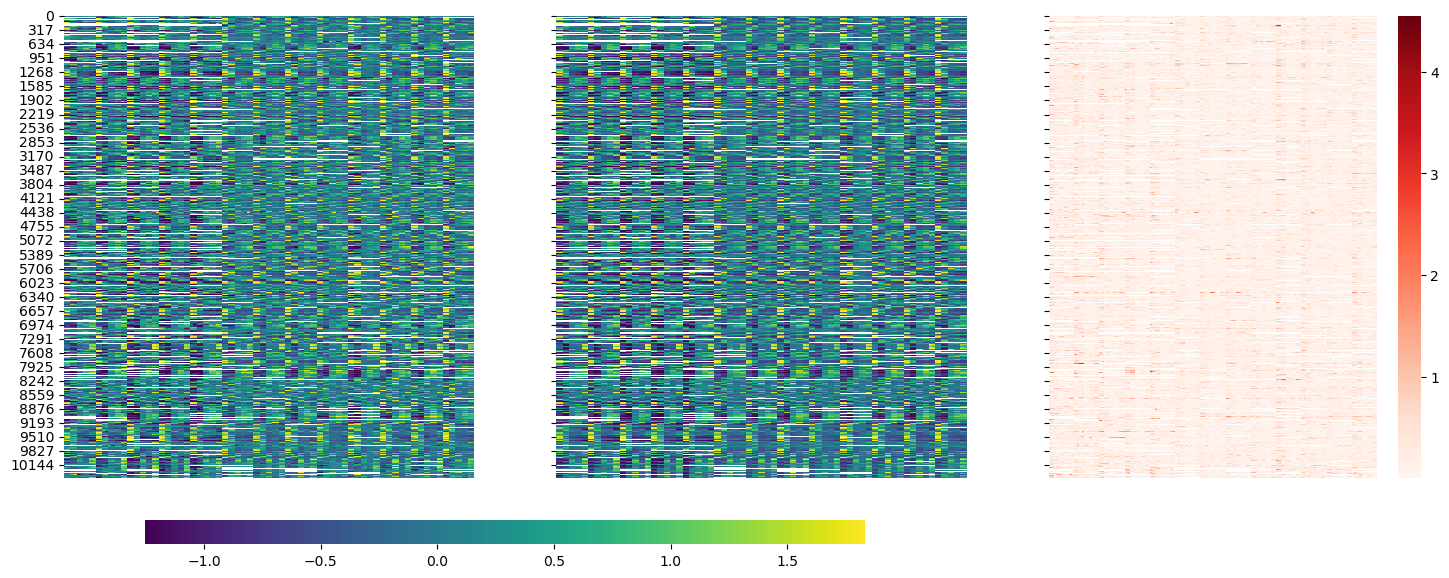

In [159]:
# Vew the whole dataset - also this validates that the row orientation before and after dimension reduction is ok 
fig, axes = plt.subplots(1,3,figsize=(18,6),sharey=True)

ax1 = sns.heatmap(npscbc_scaled, cmap="viridis",robust=True,
                  mask=mask_matrix,xticklabels=False, ax=axes[0],
                  cbar = False)

ax2 = sns.heatmap(xrec_matrix, cmap="viridis",robust=True,
                  mask=mask_matrix,xticklabels=False,ax=axes[1],
                  cbar_ax=fig.add_axes([.17, 0, .4, .04]),
                  cbar_kws={"orientation": "horizontal"})

ax3 = sns.heatmap(np.abs(npscbc_scaled-xrec_matrix), cmap="Reds",robust=False,
                  mask=mask_matrix,xticklabels=False, ax=axes[2])

### Umap based on prior knowledge 

In [160]:
# load clustered protein markers -  predefined clusters will be used as ground truth to visualize the umap coordinates of
# the latent variables 


marker_df = pd.read_csv(os.getcwd()+"\\data\\raw\\markerproteins.csv")
marker_df["Colour"].unique()
marker_df.groupby("Compartments")["Colour"].unique()

Compartments
C1       [lightblue]
C2      [aquamarine]
C3            [cyan]
C4    [deepskyblue2]
C5      [turquoise3]
M1      [burlywood4]
M2            [tan4]
N1          [grey90]
N2          [grey70]
N3          [grey50]
N4          [grey30]
S1            [gold]
S2          [orange]
S3          [salmon]
S4         [tomato2]
Name: Colour, dtype: object

In [161]:
# color headache
# Define compartments with their corresponding R colors
compartment_colors = {
    "C1": "lightblue",
    "C2": "aquamarine",
    "C3": "cyan",
    "C4": "deepskyblue2",
    "C5": "turquoise3",
    "M1": "burlywood4",
    "M2": "tan4",
    "N1": "grey90",
    "N2": "grey70",
    "N3": "grey50",
    "N4": "grey30",
    "S1": "gold",
    "S2": "orange",
    "S3": "salmon",
    "S4": "tomato2"
}

# Matplotlib color codes (converted from R colors)
color_mapping = {
    'tomato2': '#EE5C42',
    'deepskyblue2': '#03A9F4',
    'cyan': '#00FFFF',
    'turquoise3': '#00C5CD',
    'grey50': '#7F7F7F',
    'gold': '#FFD700',
    'tan4': '#8B5A2B',
    'salmon': '#FA8072',
    'orange': '#FFA500',
    'aquamarine': '#7FFFD4',
    'lightblue': '#ADD8E6',
    'burlywood4': '#8B7355',
    'grey70': '#B3B3B3',
    'grey90': '#E5E5E5',
    'grey30': '#4D4D4D'
}

# Exchange Rstudio colors with matplotlib colors
compartment_color_map = {comp: color_mapping[color] for comp, color in compartment_colors.items()}

# Each cluster is linked to a color code 
print(compartment_color_map)

marker_df["color2"] = marker_df["Compartments"].map(compartment_color_map)
marker_df.head()

{'C1': '#ADD8E6', 'C2': '#7FFFD4', 'C3': '#00FFFF', 'C4': '#03A9F4', 'C5': '#00C5CD', 'M1': '#8B7355', 'M2': '#8B5A2B', 'N1': '#E5E5E5', 'N2': '#B3B3B3', 'N3': '#7F7F7F', 'N4': '#4D4D4D', 'S1': '#FFD700', 'S2': '#FFA500', 'S3': '#FA8072', 'S4': '#EE5C42'}


,Unnamed: 0,Proteins,Compartments,Cyto,Nsol,NucI,Horg,Lorg,Colour,color2
0,AAAS,AAAS,S4,-1.003352,-1.154895,0.930337,0.485543,0.161833,tomato2,#EE5C42
1,AACS,AACS,C4,2.171657,0.132460,-1.039463,-1.132656,-1.321762,deepskyblue2,#03A9F4
2,AAK1,AAK1,C3,1.855645,0.100153,-0.660551,-0.369851,-0.674196,cyan,#00FFFF
3,AARS,AARS,C4,2.101283,0.058558,-1.043925,-1.084520,-1.218098,deepskyblue2,#03A9F4
4,AASDHPPT,AASDHPPT,C5,1.706590,0.515071,-0.719659,-0.652672,-1.005984,turquoise3,#00C5CD


In [162]:
# reconstruct the dataframes rawscbc and latentscbc

rawscbc = pd.DataFrame(npscbc_scaled, index=scbc.index)
latentscbc = pd.DataFrame(latent_matrix, index=scbc.index)

rawscbc_markers = rawscbc.loc[rawscbc.index.isin(marker_df["Proteins"])]
latentscbc_markers = latentscbc.loc[latentscbc.index.isin(marker_df["Proteins"])]
# latentscbc_markers.index == marker_df.index
latentscbc_markers.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
AAAS,0.081699,0.510033,-0.172608,-0.004251,1.031737,0.789228,0.988815,0.269666,0.838755,1.000559,...,0.172258,-0.810531,0.420379,-0.633853,0.881679,0.218618,-0.037891,-0.664398,-0.272061,0.124843
AACS,0.466530,-0.826398,-0.866024,0.802478,-0.853209,-0.904407,-0.818952,0.927637,-0.459422,-0.809769,...,-0.539442,0.950377,-0.784515,-0.411433,-0.942215,0.632298,0.082299,0.752285,0.765432,-0.465995
AAK1,0.189308,-0.441863,-0.544711,0.176636,-0.434373,-0.818684,-0.367413,0.419007,0.025741,-0.480453,...,0.092818,0.826990,-0.752881,-0.174968,-0.822646,0.240290,-0.092995,0.718352,0.582216,0.182528
AARS,0.463559,-0.866574,-0.823061,0.805715,-0.777899,-0.825182,-0.728315,0.947452,-0.354480,-0.705669,...,-0.459079,0.873017,-0.724743,-0.514511,-0.898391,0.717726,0.191699,0.775832,0.755623,-0.330214
AASDHPPT,0.435008,-0.267935,-0.761610,0.269350,-0.776108,-0.916476,-0.786821,0.413504,-0.398672,-0.812863,...,-0.006364,0.809696,-0.620209,0.088312,-0.925208,0.151028,-0.324107,0.435958,0.830160,-0.026133


In [163]:
# aplly umap and plot the 3D or 2D features cluster-wise 
# Create a UMAP object with custom parameters
umap_model = umap.UMAP(n_neighbors=30,
                           min_dist=0.15,
                           n_components=3,
                           metric="euclidean",
                           random_state=88) 
    
# Fit the UMAP model and transform the data
umap_latent = umap_model.fit_transform(latentscbc_markers)

c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [164]:
# recreate the dataframe and merge the umap coordinates with the marker df to plot in 3D
# marker_df["Proteins"]
# umap_latent["Proteins"] = latentscbc_markers.index
umap_lat_df = pd.DataFrame(umap_latent, index= latentscbc_markers.index)
umap_lat_df["Proteins"] = latentscbc_markers.index
umapz_df = pd.merge(umap_lat_df,marker_df, on="Proteins", how="left")
umapz_df.rename(columns={0:"dim1",1:"dim2",2:"dim3"}, inplace=True)
umapz_df.head(2)

,dim1,dim2,dim3,Proteins,Unnamed: 0,Compartments,Cyto,Nsol,NucI,Horg,Lorg,Colour,color2
0,6.469406,-3.045081,8.665950,AAAS,AAAS,S4,-1.003352,-1.154895,0.930337,0.485543,0.161833,tomato2,#EE5C42
1,-6.860716,4.832024,3.812721,AACS,AACS,C4,2.171657,0.132460,-1.039463,-1.132656,-1.321762,deepskyblue2,#03A9F4


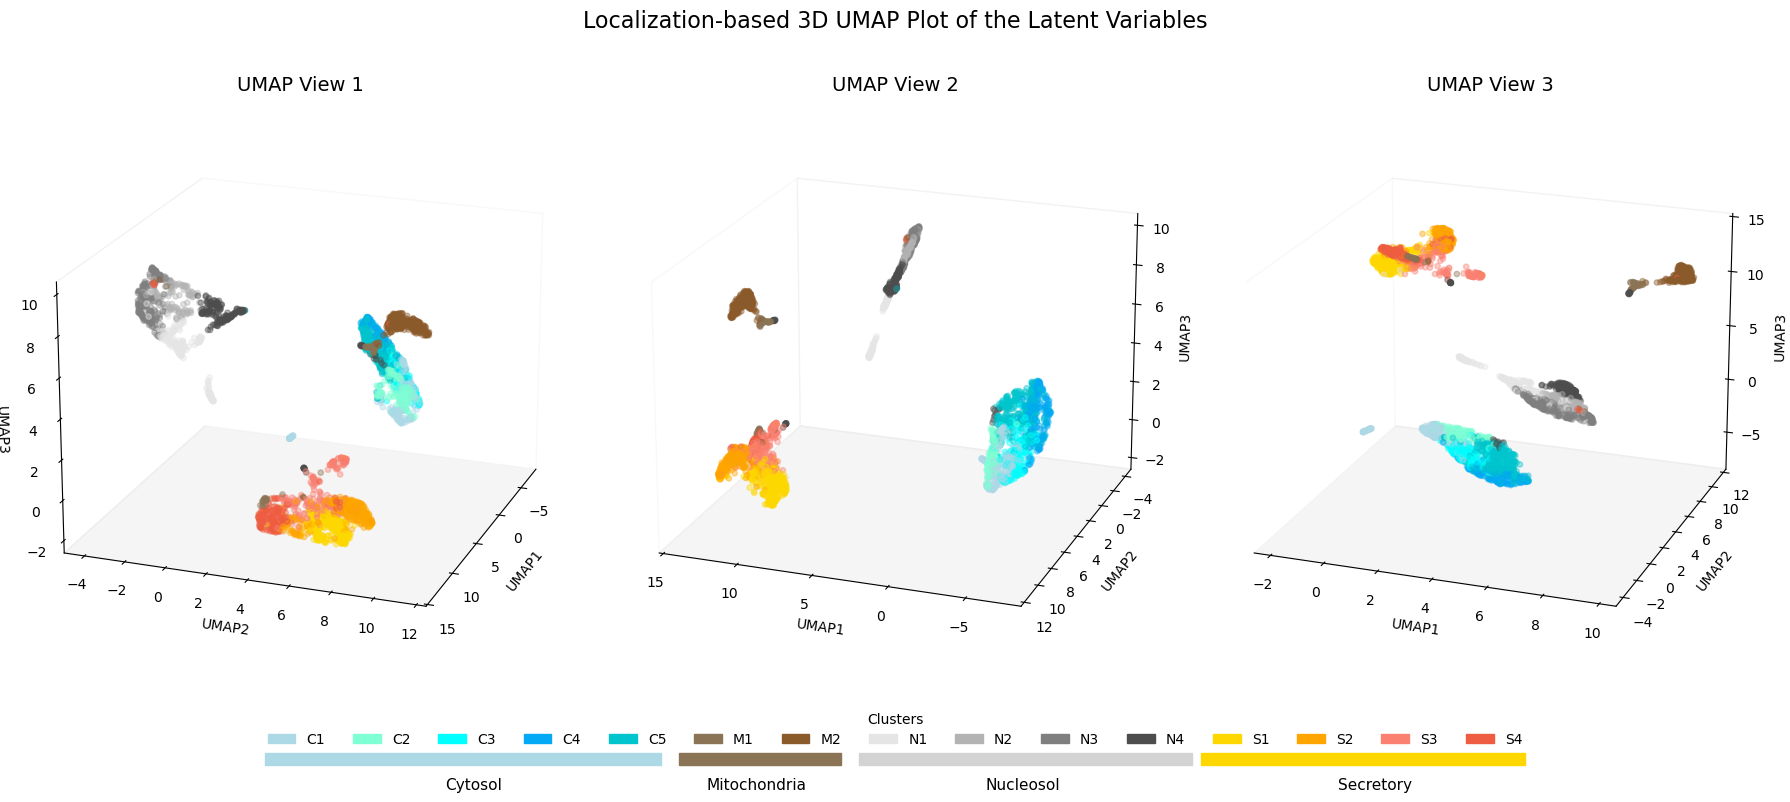

In [165]:
uf.plot_umap3d(umap_df=umapz_df,
            savepath = model_path)

In [166]:
# create an html for closer inspection 
uf.plot_umap3d_plotly(umap_df=umapz_df, savepath = model_path + "//umap3d_latent.html")

Figure saved as HTML to: c:\Users\gpano\Desktop\github_py\proteomics_latent_space\models\model_g2simSCBC_noscale__90_45//umap3d_latent.html


## 3D UMAP coords of all the dataset

In [167]:
# create and save umap coordinates for all the proteins not just the markers 
# possible for feature engineering purposes 

umap_latent_final = umap_model.fit_transform(latent_df)
umap_latent_final = pd.DataFrame(umap_latent_final, index=latent_df.index, columns=["scbc_vae_dim1", "scbc_vae_dim2", "scbc_vae_dim3"])

c:\Users\gpano\anaconda3\envs\scbc\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



### Save UMAP to model path

In [168]:
model_path
umap_latent_final

,scbc_vae_dim1,scbc_vae_dim2,scbc_vae_dim3
A2M,7.781113,3.272741,7.994605
A4GALT,1.981531,4.434201,10.279171
AAAS,3.304054,9.437568,5.620496
AACS,11.280738,3.018752,7.898703
AADAT,3.041441,2.586210,3.497725
...,...,...,...
ZYG11A,6.889436,3.681281,7.847452
ZYG11B,9.563556,4.850866,7.992203
ZYX,9.787266,4.164230,8.590339
ZZEF1,7.888473,5.440349,10.500960


In [169]:
umap_latent_final.to_csv(model_path +"\\" + data_type + "_scbc_umap.csv", index=True, header=True)

In [170]:
umap_latent_final.shape, umap_latent_final.head()


((10439, 3),
         scbc_vae_dim1  scbc_vae_dim2  scbc_vae_dim3
 A2M          7.781113       3.272741       7.994605
 A4GALT       1.981531       4.434201      10.279171
 AAAS         3.304054       9.437568       5.620496
 AACS        11.280738       3.018752       7.898703
 AADAT        3.041441       2.586210       3.497725)